In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from math import log2
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import median_absolute_error
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.pipeline import make_pipeline
import time
import matplotlib as mpl

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor



from sklearn.preprocessing import StandardScaler,PowerTransformer,MinMaxScaler,QuantileTransformer,normalize
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import pathlib
import os
import sys

# for selection the right path
import os,sys,inspect,pathlib
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from common.model_trainer_reg import *
from common.regression_plotfunctions import *

from GD.LinearRegression import LinearRegression
from KNN.KNNRegressor import KNNRegressor

import supercon_preprocessing

In [2]:
# Custom functions

module_path = pathlib.Path(os.getcwd()).parent
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))
print(sys.path)

from common.dataset_grabber import get_data_path

#https://joeganser.github.io/2019-01-26-superconductivity-regression/

['/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2/Superconductivty', '', '/home/alexander/ngsuite/ngsolve-install/lib/python3/dist-packages', '/home/alexander/ngsuite/ngsolve-install/bin', '/home/alexander/.local/bin', '/usr/local/sbin', '/usr/local/bin', '/usr/sbin', '/usr/bin', '/sbin', '/bin', '/usr/games', '/usr/local/games', '/snap/bin', '/home/alexander/.vscode/extensions/ms-toolsai.jupyter-2020.11.392013122/pythonFiles', '/home/alexander/.vscode/extensions/ms-toolsai.jupyter-2020.11.392013122/pythonFiles/lib/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/home/alexander/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-p

In [3]:
datapath = get_data_path("Superconduct", "train.csv")
display(datapath)

PosixPath('/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex2/Datasets/Superconduct/train.csv')

In [4]:
df_raw = pd.read_csv(datapath)

#df_raw = df_raw.sample(3000)

# Train and Test

In [5]:
Y, X = supercon_preprocessing.preprocessing(df_raw, transform=True)

## SGD-Regression

In [6]:
MODEL = SGDRegressor
NAME = "SGD"
PATH = "out/"+NAME+"/"
params = {"alpha" : [0.0001]}
n_splits = 2

modeltrainer = ModelTrainer(MODEL, params, X, Y)
########### train with TrainTestSplit  ###################
modeltrainer.TTSplit(perc = 0.4)
modeltrainer.train()
res = modeltrainer.result
display(res)


########### k-Fold Cross validation  ###################
modeltrainer.CV_fold(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

########### shuffle_Cross validation  ###################
#score_list_SGD = modeltrainer.CV_shuffle_split(k = n_splits, test_size = 0.4, random_state = 42)
#modeltrainer.train()
#res = modeltrainer.result
#display(res)

('alpha',) ([0.0001],)
Finished evaluation
R2_score= 0.7340828093513807
Total evaluation time = 0.30s


,alpha,train_time,inference_time,R2_score,RMSE
0,0.0001,0.063988,0.001364,0.734083,0.030421


('alpha',) ([0.0001],)
Finished evaluation
R2_score= 0.7182000163365474
Total evaluation time = 0.30s


,alpha,train_time,inference_time,R2_score,RMSE
0,0.0001,0.053195,0.001394,0.7182,0.031705


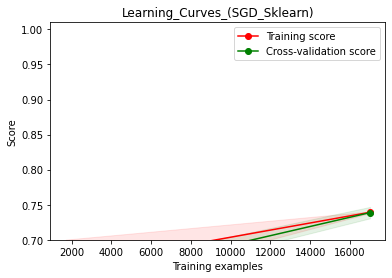

In [7]:
plt.figure()
plt.grid()

title = "Learning_Curves_(SGD_Sklearn)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=0)

estimator = SGDRegressor()
plot_learning_curve(estimator, title, X, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=4,train_sizes=np.linspace(.1, 1.0, n_splits))
plt.savefig(PATH+title)
plt.show()

In [8]:
MODEL = LinearRegression
params = {"alpha" : [0.0001], "max_iter": [1000]}

modeltrainer = ModelTrainer(MODEL, params, X, Y,thread_cnt=4)
########### train with TrainTestSplit  ###################
modeltrainer.TTSplit(perc = 0.4)
modeltrainer.train()
res = modeltrainer.result
display(res)


########### k-Fold Cross validation  ###################
modeltrainer.CV_fold(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

########### shuffle_Cross validation  ###################
#score_list_SGD_own = modeltrainer.CV_shuffle_split(k = n_splits, test_size = 0.4, random_state = 42)
#modeltrainer.train()
#res = modeltrainer.result
#display(res)

('alpha', 'max_iter') ([0.0001], [1000])
Finished evaluation
R2_score= 0.7369020944811129
Total evaluation time = 14.37s


,alpha,max_iter,train_time,inference_time,R2_score,RMSE
0,0.0001,1000,14.060957,0.001667,0.736902,0.030099


('alpha', 'max_iter') ([0.0001], [1000])
Finished evaluation
R2_score= 0.7376542770394933
Total evaluation time = 15.19s


,alpha,max_iter,train_time,inference_time,R2_score,RMSE
0,0.0001,1000,14.921857,0.010394,0.737654,0.029516


## KNN-Regression

In [9]:
MODEL = KNeighborsRegressor
params = {"weights" : ["uniform"]}
NAME = "KNN"
PATH = "out/"+NAME+"/"


modeltrainer = ModelTrainer(MODEL, params, X, Y)
########### train with TrainTestSplit  ###################
modeltrainer.TTSplit(perc = 0.4)
modeltrainer.train()
res = modeltrainer.result
display(res)


########### k-Fold Cross validation  ###################
modeltrainer.CV_fold(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

########### shuffle_Cross validation  ###################
#score_list_KNN = modeltrainer.CV_shuffle_split(k = n_splits, test_size = 0.4, random_state = 42)
#modeltrainer.train()
#res = modeltrainer.result
#display(res)

('weights',) (['uniform'],)
Finished evaluation
R2_score= 0.8917835990285802
Total evaluation time = 4.43s


,weights,train_time,inference_time,R2_score,RMSE
0,uniform,0.156291,3.932473,0.891784,0.01238


('weights',) (['uniform'],)
Finished evaluation
R2_score= 0.8860195181786119
Total evaluation time = 4.21s


,weights,train_time,inference_time,R2_score,RMSE
0,uniform,0.140171,3.764917,0.88602,0.012824


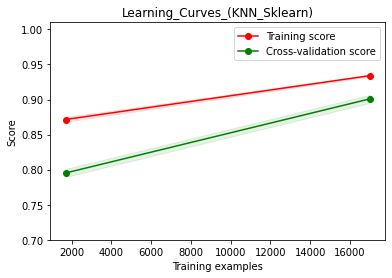

In [10]:
plt.figure()
plt.grid()

title = "Learning_Curves_(KNN_Sklearn)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=0)
#cv = train_test_split(test_size=0.4, random_state=42)

estimator = KNeighborsRegressor()
plot_learning_curve(estimator, title, X, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=4,train_sizes=np.linspace(.1, 1.0, n_splits))
plt.savefig(PATH+title)
plt.show()

In [11]:
MODEL = KNNRegressor
params = {"n_neighbors" : [5],
           "p": [2]}
NAME = "KNN"
PATH = "out/"+NAME+"/"

modeltrainer = ModelTrainer(MODEL, params, X, Y)
########### train with TrainTestSplit  ###################
modeltrainer.TTSplit(perc = 0.4)
modeltrainer.train()
res = modeltrainer.result
display(res)


########### k-Fold Cross validation  ###################
modeltrainer.CV_fold(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

########### shuffle_Cross validation  ###################
#score_list_KNN_own = modeltrainer.CV_shuffle_split(k = n_splits, test_size = 0.4, random_state = 42)
#modeltrainer.train()
#res = modeltrainer.result
#display(res)

('n_neighbors', 'p') ([5], [2])


MaybeEncodingError: Error sending result: '<multiprocessing.pool.ExceptionWithTraceback object at 0x7fb8471ec410>'. Reason: 'PicklingError("Can't pickle <class 'MemoryError'>: it's not the same object as builtins.MemoryError")'

## RF-Regression

In [ ]:
MODEL = RandomForestRegressor
params = {"n_estimators" : [100]}
NAME = "RF"
PATH = "out/"+NAME+"/"

#modeltrainer = ModelTrainer(MODEL, params, X, Y)
########### train with TrainTestSplit  ###################
#modeltrainer.TTSplit(perc = 0.4)
#modeltrainer.train()
#res = modeltrainer.result
#display(res)


########### k-Fold Cross validation  ###################
#modeltrainer.CV_fold(k = n_splits, test_size = 0.4, random_state = 42)
#modeltrainer.train()
#res = modeltrainer.result
#display(res)

########### shuffle_Cross validation  ###################
#score_list_RF = modeltrainer.CV_shuffle_split(k = n_splits, test_size = 0.4, random_state = 42)
#modeltrainer.train()
#res = modeltrainer.result
#display(res)

In [ ]:
plt.figure()
plt.grid()

title = "Learning_Curves_(RF_Sklearn)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
#cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=0)
#cv = train_test_split(test_size=0.4, random_state=42)

#estimator = RandomForestRegressor()
#plot_learning_curve(estimator, title, X, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=4,train_sizes=np.linspace(.1, 1.0, n_splits))
#plt.savefig(PATH+title)
#plt.show()

## DT-Regression

In [16]:
MODEL = DecisionTreeRegressor
params = {"criterion": ["mse"]}
NAME = "DT"
PATH = "out/"+NAME+"/"


modeltrainer = ModelTrainer(MODEL, params, X, Y)
########### train with TrainTestSplit  ###################
modeltrainer.TTSplit(perc = 0.4)
modeltrainer.train()
res = modeltrainer.result
display(res)


########### k-Fold Cross validation  ###################
modeltrainer.CV_fold(k = n_splits, test_size = 0.4, random_state = 42)
modeltrainer.train()
res = modeltrainer.result
display(res)

########### shuffle_Cross validation  ###################
#score_list_DT = modeltrainer.CV_shuffle_split(k = n_splits, test_size = 0.4, random_state = 42)
#modeltrainer.train()
#res = modeltrainer.result
#display(res)

('criterion',) (['mse'],)
Finished evaluation
R2_score= 0.8466214339901031
Total evaluation time = 1.62s


,criterion,train_time,inference_time,R2_score,RMSE
0,mse,1.246963,0.004094,0.846621,0.017547


('criterion',) (['mse'],)
Finished evaluation
R2_score= 0.8597875670691131
Total evaluation time = 1.52s


,criterion,train_time,inference_time,R2_score,RMSE
0,mse,1.216784,0.004665,0.859788,0.015775


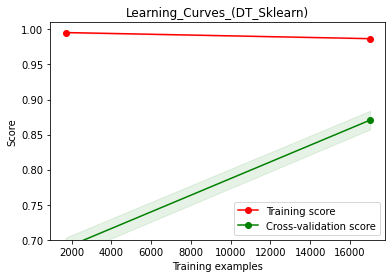

In [17]:
plt.figure()
plt.grid()

title = "Learning_Curves_(DT_Sklearn)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=0)
#cv = train_test_split(test_size=0.4, random_state=42)

estimator = DecisionTreeRegressor()
plot_learning_curve(estimator, title, X, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=4,train_sizes=np.linspace(.1, 1.0, n_splits))
plt.savefig(PATH+title)
plt.show()

In [ ]:
#plot_learning_curve_own(score_list_SGD,"SGD", ylim=(0.35, 1.01))
#plot_learning_curve_own(score_list_KNN,"KNN")
#plot_learning_curve_own(score_list_RF,"RF")
#plot_learning_curve_own(score_list_DT,"DT")
#plt.savefig("out/shuffle_vs_score")

In [ ]:
#plot_learning_curve_own(score_list_SGD_own,"SGD_own", ylim=(0.2, 1.01))
#plot_learning_curve_own(score_list_KNN_own,"KNN_own")
#plt.savefig("out/shuffle_own_vs_score")